**Goal**: sample the warnings to manually inspect and create plots based on those.

In [1]:
import project_path
from rdlib import *  # this imports the base libraries

import glob
from typing import Dict, List
import re
import yaml
import json
from tqdm import tqdm
from sarif import loader
import shutil
import random

# DATA
# SARIF_FOLDER = "../data/analysis_results/exp_v08/codeql_2023-09-14_11-53-38/"
# SARIF_FOLDER = "../data/analysis_results/exp_v08/codeql_2023-09-14_14-02-32/"
# SARIF_FOLDER = "../data/analysis_results/exp_v08/codeql_2023-09-14_15-14-24/"  # FULLY INSPECTED - ANN 1
# SARIF_FOLDER = "../data/analysis_results/exp_v08/codeql_2023-09-14_18-10-35/"  # PARTIALLY - ANN 2
SARIF_FOLDER = "../data/analysis_results/exp_v08/codeql_2023-09-15_19-14-06"
MAIN_FOLDER_DATA = "../data/datasets/exp_v08/files_selected"
path_to_sarif_file = os.path.join(SARIF_FOLDER, "data.sarif")

# SAMPLING
FIXED_SAMPLE_SIZE = 10
CONFIDENCE_LEVEL = .90
MARGIN_ERROR = .10
RND_SEED = 42

# RULES
NAME_MAPPING = {
    # measurement
    # ---
    'ql-double-measurement': 'DoubleMeas',
    'DoubleMeasurement.ql': 'DoubleMeas',
    # ---
    'ql-operation-after-measurement': 'OpAfterMeas',
    'OpAfterMeasurement.ql': 'OpAfterMeas',
    # ---
    'ql-measure-all-abuse': 'MeasAllAbuse',
    'MeasureAll.ql': 'MeasAllAbuse',
    # ---
    'ql-constant-classic-bit': 'ConstClasBit',
    'ConstantClassicBit.ql': 'ConstClasBit',

    # composition
    # ---
    'ql-incompatible-composition': 'IncompCompose',
    'IncompatibleComposition.ql': 'IncompCompose',
    # ---
    'ql-ungoverned-composition': 'UngovCompose',
    'UngovernedComposition.ql': 'UngovCompose',
    # ---
    'ql-ghost-composition': 'GhostCompose',
    'GhostComposition.ql': 'GhostCompose',

    # resources
    # ---
    'ql-unmeasurable-qubits': 'InsuffClasReg',
    'UnmeasurableQubits.ql': 'InsuffClasReg',
    # ---
    'ql-oversized-circuit': 'OversizedCircuit',
    'OversizedCircuit.ql': 'OversizedCircuit',
    # ---
    'ql-superfluous-op': 'SuperfluousOp',
    'SuperfluousOp.ql': 'SuperfluousOp',

    # conditional control flow
    # ---
    'ql-conditional-without-measurement': 'CondWoMeas',
    'ConditionalGateWithoutMeas.ql': 'CondWoMeas',

    # optimization
    # ---
    'ql-op-after-optimization': 'OpAfterTransp',
    'OpAfterOptimization.ql': 'OpAfterTransp',
}

RULE_NAME_MAPPING = {
    k: v for k, v in NAME_MAPPING.items() if k.startswith('ql-')
}
FILE_NAME_RULE_MAPPING = {
    k: v for k, v in NAME_MAPPING.items() if k.endswith('.ql')
}


In [2]:
# LOAD SARIF AS JSON
with open(path_to_sarif_file, "r") as f:
    sarif = json.load(f)

sarif_results = sarif["runs"][0]["results"]


Text(0.5, 0, 'number of warnings')

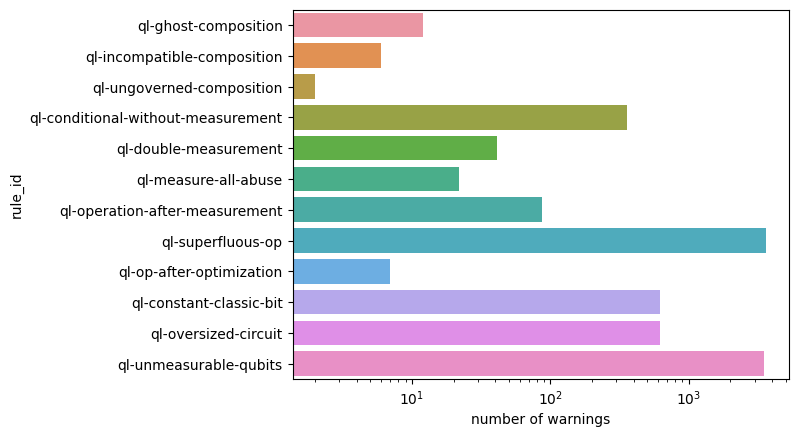

In [3]:
def get_df_from_sarif(sarif_results: List[Dict[str, Any]]):
    """Create a dataset from sarif results."""
    def process(record: Dict[str, Any]):
        """Parse some key info from the record."""
        region = record["locations"][0]["physicalLocation"].get("region", None)
        line, col = None, None
        if region:
            line = region.get("startLine", None)
            col = region.get("startColumn", None)
        return {
            "rule_id": record["ruleId"],
            "message": record["message"]["text"],
            "file": record["locations"][0]["physicalLocation"]["artifactLocation"]["uri"],
            "line": line,
            "col": col,
        }

    processed_results = [
        process(result)
        for result in sarif_results
    ]

    df_results = pd.DataFrame.from_records(processed_results)
    return df_results

df_results = get_df_from_sarif(sarif_results)

# keep relevant rule_id in RULE_NAME_MAPPING
df_results = df_results[df_results["rule_id"].isin(RULE_NAME_MAPPING.keys())]

df_results.head()

sns.countplot(
    data=df_results,
    y="rule_id",
)
# log scale
plt.xscale("log")
plt.xlabel("number of warnings")

In [4]:
df_results["rule_id"].value_counts()

rule_id
ql-superfluous-op                     3613
ql-unmeasurable-qubits                3489
ql-constant-classic-bit                622
ql-oversized-circuit                   621
ql-conditional-without-measurement     356
ql-operation-after-measurement          87
ql-double-measurement                   41
ql-measure-all-abuse                    22
ql-ghost-composition                    12
ql-op-after-optimization                 7
ql-incompatible-composition              6
ql-ungoverned-composition                2
Name: count, dtype: int64

In [5]:

def compute_representative_sample_size(
        population_size, margin_error=.05,confidence_level=.95,sigma=1/2):
    """Calculate sample size for a representative sample of the population.
    
    Credits: https://github.com/shawnohare/samplesize/blob/master/samplesize.py
    """

    alpha = 1 - (confidence_level)
    zdict = {
        .90: 1.645,
        .91: 1.695,
        .99: 2.576,
        .97: 2.17,
        .94: 1.881,
        .93: 1.812,
        .95: 1.96,
        .98: 2.326,
        .96: 2.054,
        .92: 1.751
    }
    if confidence_level in zdict:
        z = zdict[confidence_level]
    else:
        from scipy.stats import norm
        z = norm.ppf(1 - (alpha/2))
    N = population_size
    M = margin_error
    numerator = z**2 * sigma**2 * (N / (N-1))
    denom = M**2 + ((z**2 * sigma**2)/(N-1))
    return int(numerator/denom + 0.5)

compute_representative_sample_size(10000, margin_error=.05,confidence_level=.95,sigma=1/2)

370

In [6]:
sampled_results = []

# for each rule, sort them alphabetically by filename, 
# then sample 10
all_rules = df_results["rule_id"].unique()
relevant_rules = [rule for rule in all_rules if rule in RULE_NAME_MAPPING.keys()]

def sample(
        sarif_results: List[Dict[str, Any]],
        relevant_rules: List[str],
        fixed_sample_size=10,
        confidence_level=0.90,
        margin_error=0.10,
        random_seed=42,
        representative_sample_superset=False,):
    """Sample warnings from each rule."""
    sampled_results = []
    for rule in relevant_rules:
        # SET SEED FOR EACH RULE
        random.seed(random_seed)
        warnings_of_i_rule = [
            result 
            for result in sarif_results
            if result["ruleId"] == rule
        ]
        # sort them by filename
        warnings_of_i_rule = sorted(
            warnings_of_i_rule, 
            key=lambda x: x["locations"][0]["physicalLocation"]["artifactLocation"]["uri"]
        )
        representative_sample_size = compute_representative_sample_size(
            population_size=len(warnings_of_i_rule), 
            margin_error=margin_error,
            confidence_level=confidence_level
        )
        # consider all 
        sample_i_rule = warnings_of_i_rule
        # get the largest representative sample first
        if representative_sample_size > fixed_sample_size:
            if len(sample_i_rule) > representative_sample_size:
                sample_i_rule = random.sample(sample_i_rule, representative_sample_size)
        
        # condition to trigger the fixed sample size
        if not representative_sample_superset:
            if len(sample_i_rule) > fixed_sample_size:
                sample_i_rule = random.sample(sample_i_rule, fixed_sample_size)
        
        print(f"{len(warnings_of_i_rule)} >> {len(sample_i_rule)}\t ({rule})") 
        sampled_results.extend(sample_i_rule)
    return sampled_results

sarif_sample_fixed = sample(
    sarif_results=sarif_results,
    relevant_rules=relevant_rules,
    fixed_sample_size=FIXED_SAMPLE_SIZE
)
df_results_sample_fixed = get_df_from_sarif(sarif_sample_fixed)
print(f"FIXED: total sample size: {len(df_results_sample_fixed)}")
print('-' * 80)

sarif_sample_representative = sample(
    sarif_results=sarif_results,
    relevant_rules=relevant_rules,
    fixed_sample_size=FIXED_SAMPLE_SIZE,
    representative_sample_superset=True,
)
df_results_sample_representative = get_df_from_sarif(sarif_sample_representative)
print(f"REPRESENTATIVE: total sample size: {len(df_results_sample_representative)}")
print('-' * 80)
    


12 >> 10	 (ql-ghost-composition)
6 >> 6	 (ql-incompatible-composition)
2 >> 2	 (ql-ungoverned-composition)
356 >> 10	 (ql-conditional-without-measurement)
41 >> 10	 (ql-double-measurement)
22 >> 10	 (ql-measure-all-abuse)
87 >> 10	 (ql-operation-after-measurement)
3613 >> 10	 (ql-superfluous-op)
7 >> 7	 (ql-op-after-optimization)
622 >> 10	 (ql-constant-classic-bit)
621 >> 10	 (ql-oversized-circuit)
3489 >> 10	 (ql-unmeasurable-qubits)
FIXED: total sample size: 105
--------------------------------------------------------------------------------
12 >> 12	 (ql-ghost-composition)
6 >> 6	 (ql-incompatible-composition)
2 >> 2	 (ql-ungoverned-composition)
356 >> 57	 (ql-conditional-without-measurement)
41 >> 26	 (ql-double-measurement)
22 >> 17	 (ql-measure-all-abuse)
87 >> 38	 (ql-operation-after-measurement)
3613 >> 66	 (ql-superfluous-op)
7 >> 7	 (ql-op-after-optimization)
622 >> 61	 (ql-constant-classic-bit)
621 >> 61	 (ql-oversized-circuit)
3489 >> 66	 (ql-unmeasurable-qubits)
REPRESENT

In [7]:
# check that all the fixed size records are in the representative one
df_intersection = df_results_sample_fixed.merge(
    df_results_sample_representative,
    how="inner",
    on=["rule_id", "message", "file", "line", "col"],
    suffixes=("_fixed", "_representative")
)
assert len(df_intersection) == len(df_results_sample_fixed)

In [8]:
# export - FIXED, 
to_export = [
    # FIXED SIZE
    {
        'sarif_results': sarif_sample_fixed,
        'prefix': f"data_sample_fixed_{FIXED_SAMPLE_SIZE}"
    },
    # REPRESENTATIVE
    {
        'sarif_results': sarif_sample_representative,
        'prefix': f"data_sample_representative_{FIXED_SAMPLE_SIZE}"
    },
    # DELTA
    {
        'sarif_results': [
            result for result in sarif_sample_representative
            if result not in sarif_sample_fixed],
        'prefix': f"data_sample_delta_{FIXED_SAMPLE_SIZE}"
    }
]

for i_to_export in to_export:
    print("-" * 80)
    new_sarif_i = sarif.copy()
    i_results = i_to_export["sarif_results"]
    i_prefix = i_to_export["prefix"]
    new_sarif_i["runs"][0]["results"] = i_results
    with open(os.path.join(SARIF_FOLDER, f"{i_prefix}.sarif"), "w") as f:
        json.dump(new_sarif_i, f)
    # copy all the files in a dedicated folder
    # create folder in the sarif one with pathlib
    i_subfolder_path = os.path.join(SARIF_FOLDER, i_prefix)
    pathlib.Path(i_subfolder_path).mkdir(parents=True, exist_ok=True)
    # add a gitignore in the subfolder
    with open(os.path.join(i_subfolder_path, ".gitignore"), "w") as f:
        f.write("*")
    i_all_filenames = [
        result["locations"][0]["physicalLocation"]["artifactLocation"]["uri"]
        for result in i_results
    ]
    i_ORIGINAL_filepaths = [
        os.path.join(MAIN_FOLDER_DATA, filename) for filename in i_all_filenames]
    print(i_ORIGINAL_filepaths[:5])
    # copy from original to the i_subfolder
    for filepath in tqdm(i_ORIGINAL_filepaths):
        shutil.copy(filepath, i_subfolder_path)
    # create dataframe 
    i_df = get_df_from_sarif(i_results)
    i_df.to_csv(
        os.path.join(SARIF_FOLDER, f"{i_prefix}.csv"), index=False)
    print(
        f"Exported {len(i_results)} results to " +
        "{i_filename}.sarif and {i_filename}.csv")
    print(f"Exported {len(i_ORIGINAL_filepaths)} files to {os.path.basename(i_subfolder_path)}")

--------------------------------------------------------------------------------
['../data/datasets/exp_v08/files_selected/test_mc_gate_13ba80.py', '../data/datasets/exp_v08/files_selected/error_correction_repetition_code_e94ab1.py', '../data/datasets/exp_v08/files_selected/error_correction_repetition_code_e94ab1.py', '../data/datasets/exp_v08/files_selected/h2evo_6bb46f.py', '../data/datasets/exp_v08/files_selected/error_correction_repetition_code_e94ab1.py']


  0%|          | 0/105 [00:00<?, ?it/s]

100%|██████████| 105/105 [00:00<00:00, 222.44it/s]


Exported 105 results to {i_filename}.sarif and {i_filename}.csv
Exported 105 files to data_sample_fixed_10
--------------------------------------------------------------------------------
['../data/datasets/exp_v08/files_selected/error_correction_repetition_code_e94ab1.py', '../data/datasets/exp_v08/files_selected/error_correction_repetition_code_e94ab1.py', '../data/datasets/exp_v08/files_selected/error_correction_repetition_code_e94ab1.py', '../data/datasets/exp_v08/files_selected/error_correction_repetition_code_e94ab1.py', '../data/datasets/exp_v08/files_selected/h2evo_6bb46f.py']


100%|██████████| 419/419 [00:01<00:00, 245.09it/s]


Exported 419 results to {i_filename}.sarif and {i_filename}.csv
Exported 419 files to data_sample_representative_10
--------------------------------------------------------------------------------
['../data/datasets/exp_v08/files_selected/h2evoqlm_f7e7b5.py', '../data/datasets/exp_v08/files_selected/shor_df608f.py', '../data/datasets/exp_v08/files_selected/task_0f414b.py', '../data/datasets/exp_v08/files_selected/five_qubit_stabilizer_728e76.py', '../data/datasets/exp_v08/files_selected/example_qiskit_conditional_67fb51.py']


100%|██████████| 314/314 [00:00<00:00, 346.05it/s]

Exported 314 results to {i_filename}.sarif and {i_filename}.csv
Exported 314 files to data_sample_delta_10


In [9]:
PATH_ANNOTATIONS = os.path.join(SARIF_FOLDER, "Annotation_data_sample_fixed_10.csv")
df_annotations = pd.read_csv(PATH_ANNOTATIONS)
col_annot = "Annotator_1"
col_rule = "rule_id"

def discretize_negative(value) -> str:
    if "FP" in value: 
        return "FP"
    if "NW" in value:
        return "NW"
    return value

def discretize_positive(value) -> str:
    if "TP" in value:
        return "TP"
    if "NW" in value:
        return "NW"
    return value

df_pos = df_annotations.copy()
df_pos[col_annot] = df_pos[col_annot].apply(discretize_positive)
df_neg = df_annotations.copy()
df_neg[col_annot] = df_neg[col_annot].apply(discretize_negative)


def plot_stack(df, title, ax):
    df_plot = df.groupby([col_annot, col_rule]).size().reset_index().pivot(columns=col_annot, index=col_rule, values=0)
    # color map:
    # FP > red
    # NW > gray
    # TP > green
    df_plot.plot(kind='barh', stacked=True, title=title, ax=ax, color=["lightcoral", "lightblue", "springgreen"])

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
plot_stack(df_pos, "Positive", ax=axes[0])
plot_stack(df_neg, "Negative", ax=axes[1])

FileNotFoundError: [Errno 2] No such file or directory: '../data/analysis_results/exp_v08/codeql_2023-09-15_19-14-06/Annotation_data_sample_fixed_10.csv'